In [4]:
!git clone https://github.com/steve7158/self-driving-car-simulator.git
  

Cloning into 'self-driving-car-simulator'...
remote: Enumerating objects: 16617, done.
remote: Counting objects: 100% (16617/16617), done.
remote: Compressing objects: 100% (16613/16613), done.
remote: Total 16617 (delta 4), reused 16612 (delta 2), pack-reused 0
Receiving objects: 100% (16617/16617), 212.88 MiB | 42.00 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (16618/16618), done.


In [5]:
!ls self-driving-car-simulator/data/



driving_log.csv  IMG


In [6]:
!pip3 install imgaug

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from imgaug import augmenters as iaa
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import ntpath
import random
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [76]:
datadir='self-driving-car-simulator/data'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/home/steve/Self Driving Car/data/IMG/center_2019_06_02_11_21_56_169.jpg,/home/steve/Self Driving Car/data/IMG/left_2019_06_02_11_21_56_169.jpg,/home/steve/Self Driving Car/data/IMG/right_2019_06_02_11_21_56_169.jpg,0.0,0.0,0.0,0.000079
1,/home/steve/Self Driving Car/data/IMG/center_2019_06_02_11_21_56_269.jpg,/home/steve/Self Driving Car/data/IMG/left_2019_06_02_11_21_56_269.jpg,/home/steve/Self Driving Car/data/IMG/right_2019_06_02_11_21_56_269.jpg,0.0,0.0,0.0,0.000084
2,/home/steve/Self Driving Car/data/IMG/center_2019_06_02_11_21_56_403.jpg,/home/steve/Self Driving Car/data/IMG/left_2019_06_02_11_21_56_403.jpg,/home/steve/Self Driving Car/data/IMG/right_2019_06_02_11_21_56_403.jpg,0.0,0.0,0.0,0.000080
3,/home/steve/Self Driving Car/data/IMG/center_2019_06_02_11_21_56_505.jpg,/home/steve/Self Driving Car/data/IMG/left_2019_06_02_11_21_56_505.jpg,/home/steve/Self Driving Car/data/IMG/right_2019_06_02_11_21_56_505.jpg,0.0,0.0,0.0,0.000080
4,/home/steve/Self Driving Car/data/IMG/center_2019_06_02_11_21_56_638.jpg,/home/steve/Self Driving Car/data/IMG/left_2019_06_02_11_21_56_638.jpg,/home/steve/Self Driving Car/data/IMG/right_2019_06_02_11_21_56_638.jpg,0.0,0.0,0.0,0.000078


In [77]:
def path_leaf(path):
  head, tail=ntpath.split(path)
  return tail

data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_06_02_11_21_56_169.jpg,left_2019_06_02_11_21_56_169.jpg,right_2019_06_02_11_21_56_169.jpg,0.0,0.0,0.0,0.000079
1,center_2019_06_02_11_21_56_269.jpg,left_2019_06_02_11_21_56_269.jpg,right_2019_06_02_11_21_56_269.jpg,0.0,0.0,0.0,0.000084
2,center_2019_06_02_11_21_56_403.jpg,left_2019_06_02_11_21_56_403.jpg,right_2019_06_02_11_21_56_403.jpg,0.0,0.0,0.0,0.000080
3,center_2019_06_02_11_21_56_505.jpg,left_2019_06_02_11_21_56_505.jpg,right_2019_06_02_11_21_56_505.jpg,0.0,0.0,0.0,0.000080
4,center_2019_06_02_11_21_56_638.jpg,left_2019_06_02_11_21_56_638.jpg,right_2019_06_02_11_21_56_638.jpg,0.0,0.0,0.0,0.000078


[  10    8   15   17   10   26   49  179   73   64  120  149 4213  155
   91   44   74  129   42   18   10   12   13    6   11]
[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


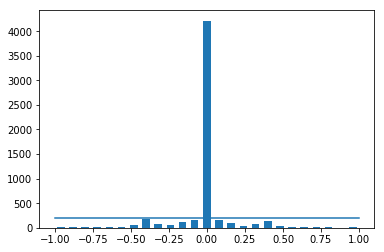

In [78]:
num_bins=25
samples_per_bin=200
hist, bins=np.histogram(data['steering'], num_bins)
center=(bins[:-1]+bins[1:])*0.5
print(hist)
print(center)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 5538
removed: 4013
remaining: 1525


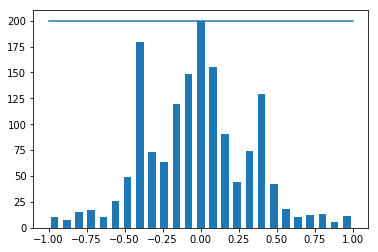

In [79]:
print('total data:', len(data))
remove_list=[]
for j in range(num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_=shuffle(list_)
  list_=list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:',len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:',len(data))
hist,_=np.histogram(data['steering'],(num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [52]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center, left, right=indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(indexed_data[3])
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths, steerings
image_paths, steerings=load_img_steering(datadir + '/IMG', data)


center      center_2019_06_02_11_21_58_442.jpg
left        left_2019_06_02_11_21_58_442.jpg  
right       right_2019_06_02_11_21_58_442.jpg 
steering   -0.0606294                         
throttle    1                                 
reverse     0                                 
speed       15.5862                           
Name: 18, dtype: object


In [80]:
X_train, X_valid, y_train, y_valid=train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

# X_valid
X_train

array(['self-driving-car-simulator/data/IMG/center_2019_06_02_11_23_59_734.jpg',
       'self-driving-car-simulator/data/IMG/center_2019_06_02_11_21_58_340.jpg',
       'self-driving-car-simulator/data/IMG/center_2019_06_02_11_27_33_903.jpg',
       ...,
       'self-driving-car-simulator/data/IMG/center_2019_06_02_11_23_34_800.jpg',
       'self-driving-car-simulator/data/IMG/center_2019_06_02_11_27_24_011.jpg',
       'self-driving-car-simulator/data/IMG/center_2019_06_02_11_28_46_391.jpg'],
      dtype='<U70')

In [54]:
print(len(X_train), len(X_valid))


1220 305


25


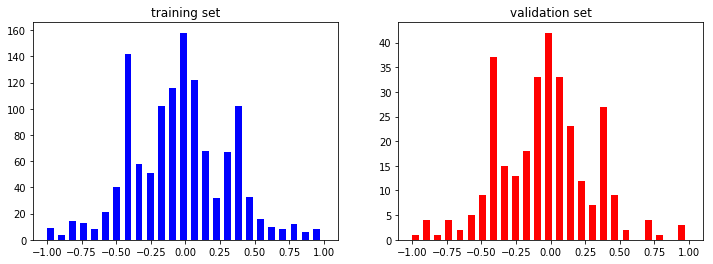

In [55]:
fig,axs=plt.subplots(1,2,figsize=(12,4))
axs[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axs[0].set_title('training set') 
axs[1].hist(y_valid,bins=num_bins, width=.05, color='red')
axs[1].set_title('validation set')
print(num_bins)

In [0]:
def zoom(image):
  zoom=iaa.Affine(scale=(1, 1.3))
  image=zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed image')

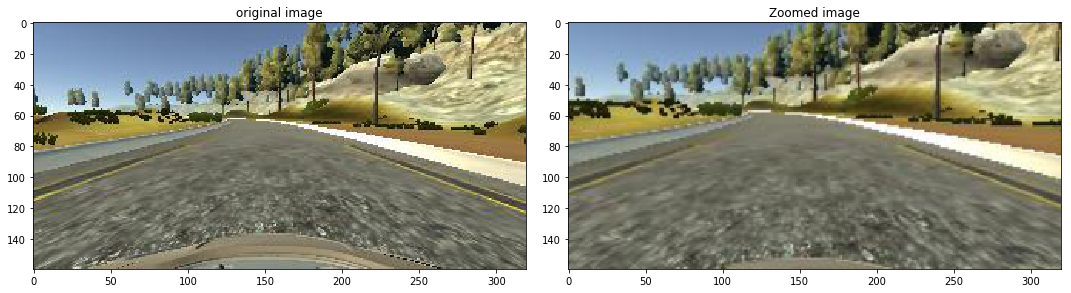

In [57]:
image=image_paths[random.randint(0, 1000)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)

fig, axs=plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed image')

In [0]:
def pan(image):
  pan=iaa.Affine(translate_percent={"x":(-0.1, 0.1), "y":(-0.1,0.1)})
  image=pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned image')

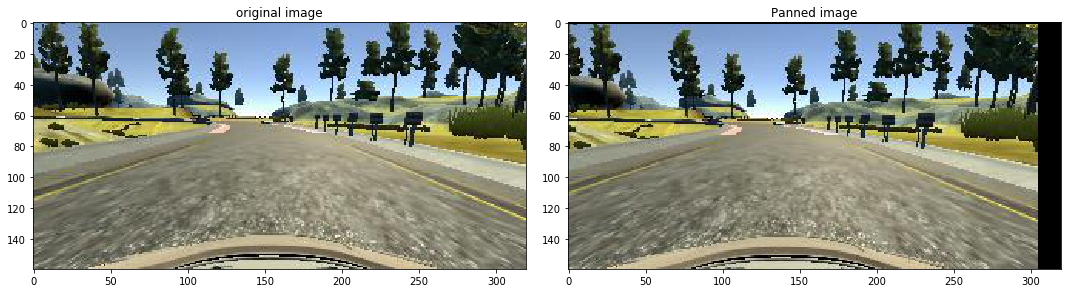

In [59]:
image=image_paths[random.randint(0, 1000)]
original_image=mpimg.imread(image)
panned_image=pan(original_image)

fig, axs=plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

In [0]:
def img_random_brightness(image):
  brightness=iaa.Multiply((0.2, 1.2))
  image=brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness altered image')

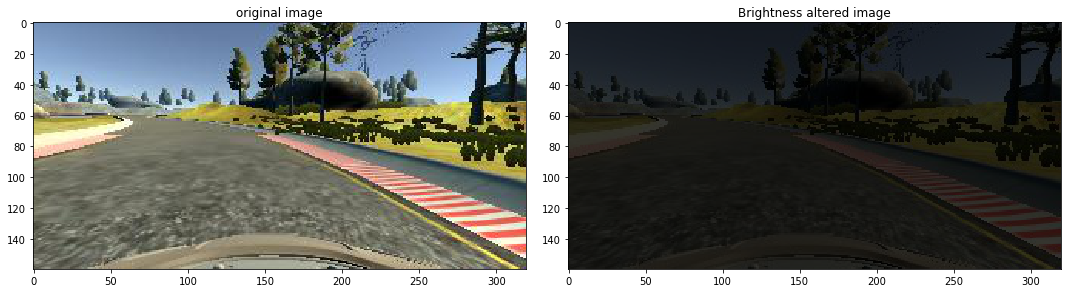

In [61]:
image=image_paths[random.randint(0, 1000)]
original_image=mpimg.imread(image)
brightness_altered_image=img_random_brightness(original_image)

fig, axs=plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image')

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle=-steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped image - Steering Angle - 0.4175856')

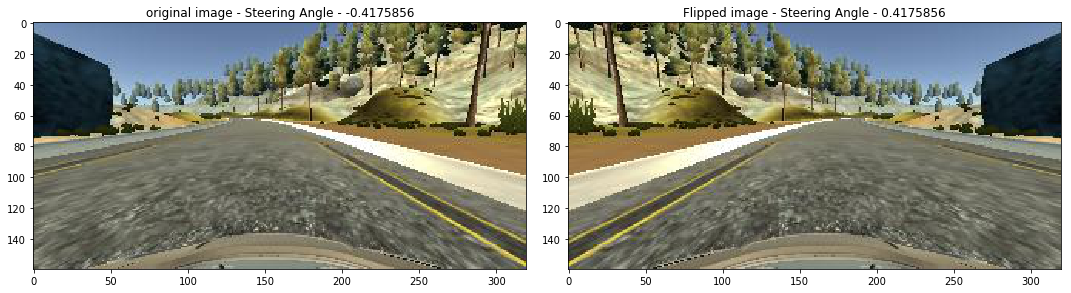

In [63]:
random_index=random.randint(0,1000)
image=image_paths[random_index]
steering_angle=steerings[random_index]

original_image=mpimg.imread(image)
flip_image, flip_steering_angle=img_random_flip(original_image, steering_angle)


fig, axs=plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original image - ' + 'Steering Angle - ' + str(steering_angle))

axs[1].imshow(flip_image)
axs[1].set_title('Flipped image - ' + 'Steering Angle - '+str(flip_steering_angle) )

In [0]:
def random_augment(image, steering_angle):
  image=mpimg.imread(image)
  if np.random.rand()<0.5:
    image=pan(image)
  if np.random.rand()<0.5:
    image=zoom(image)
  if np.random.rand() < 0.5:
    image=img_random_brightness(image)
  if np.random.rand()<0.5:
    image, steering_angle=img_random_flip(image, steering_angle)
  return image, steering_angle

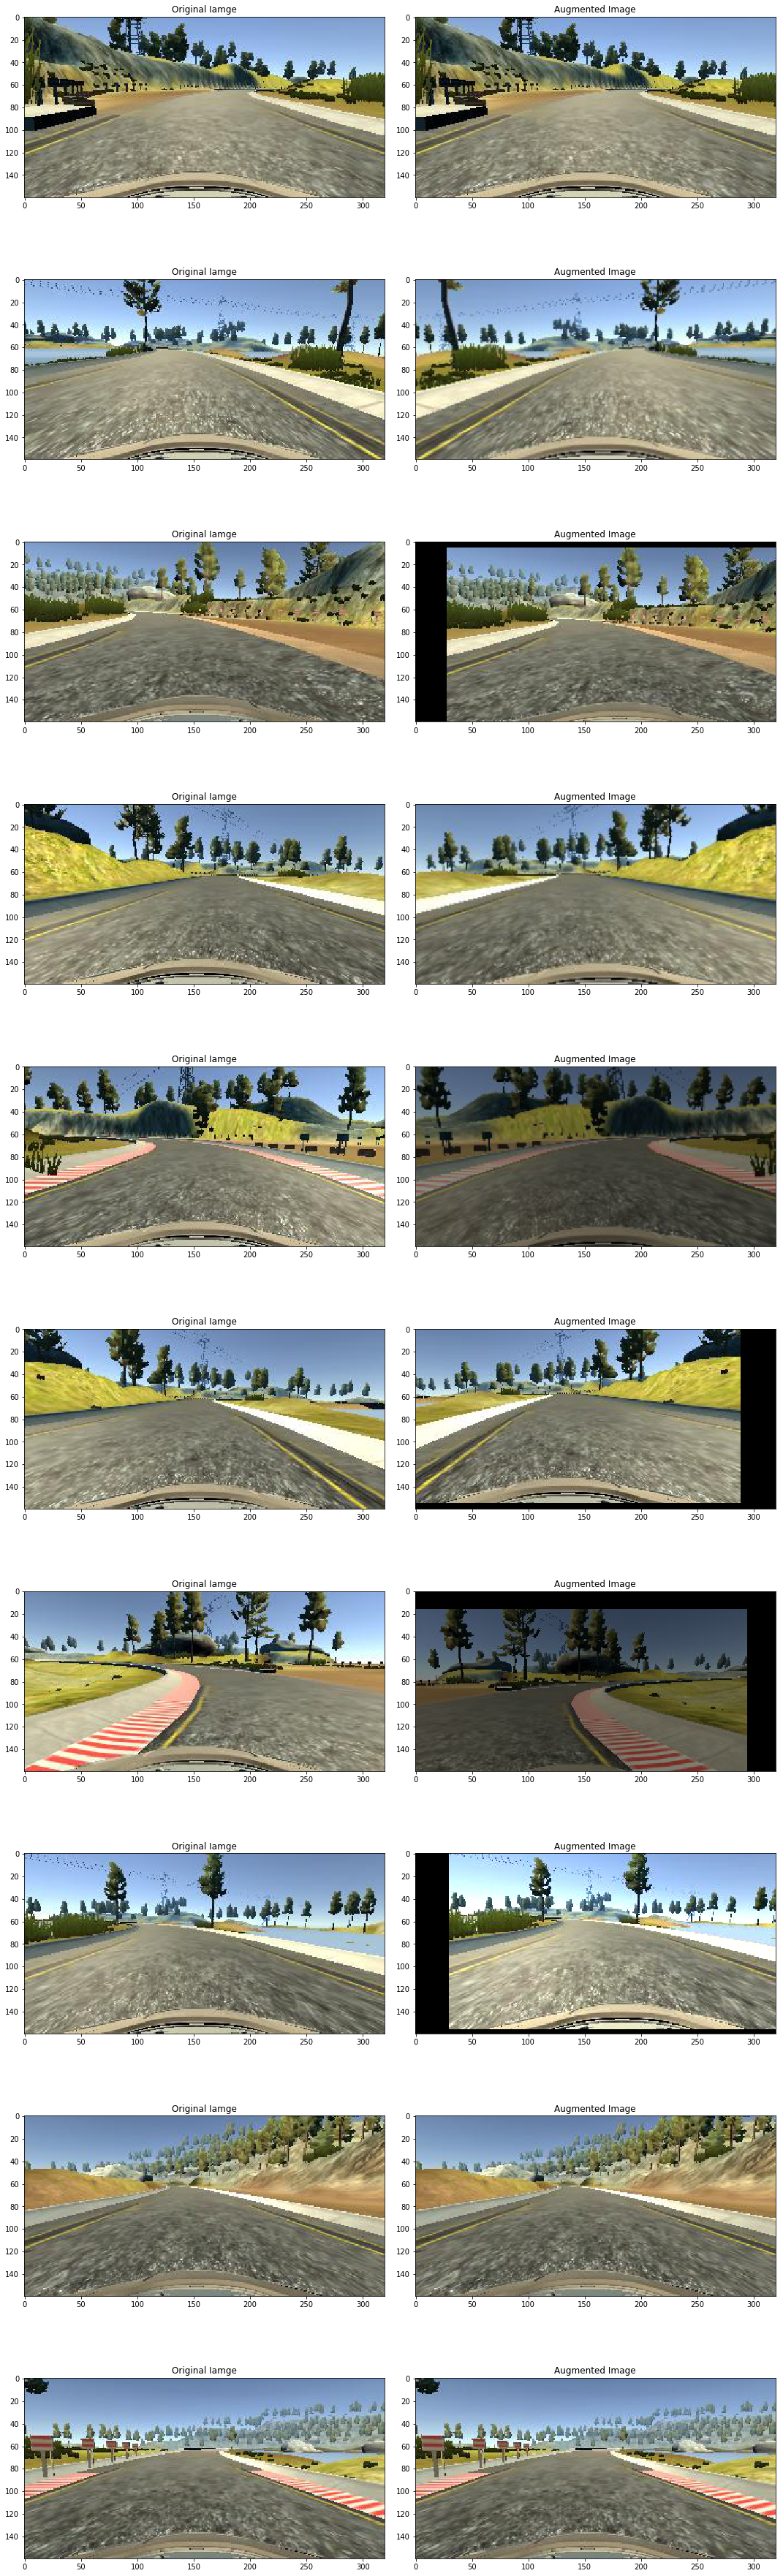

In [71]:
ncol=2
nrow=10
fig, axs=plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum=random.randint(0, len(image_paths)-1)
  random_image=image_paths[randnum]
  random_steering=steerings[randnum]
  
  original_image=mpimg.imread(random_image)
  augmented_image, steering=random_augment(random_image, random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Iamge')
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [0]:
def image_preprocess(img):
  img=mpimg.imread(img)
  img=img[60:135,:,:]
  img=cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img, (3,3), 0)
  img=cv2.resize(img, (200,66))
  img=img/255
  
  return img


In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img=[]
    batch_steering=[]
    
    for i in range(batch_size):
      random_index=random.randint(0, len(image_paths)-1)
      
      if istraining:
        im, steering=random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im=mpimg.imread(image_paths[random_index])
        steering=steering_ang[random_index]
        
      im=image_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield(np.asarray(batch_img), np.asarray(batch_steering))
     
      

In [86]:
print(X_train, y_train)
x_train_gen, y_train_gen=next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen=next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs=plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('validation image')

['self-driving-car-simulator/data/IMG/center_2019_06_02_11_23_59_734.jpg'
 'self-driving-car-simulator/data/IMG/center_2019_06_02_11_21_58_340.jpg'
 'self-driving-car-simulator/data/IMG/center_2019_06_02_11_27_33_903.jpg'
 ...
 'self-driving-car-simulator/data/IMG/center_2019_06_02_11_23_34_800.jpg'
 'self-driving-car-simulator/data/IMG/center_2019_06_02_11_27_24_011.jpg'
 'self-driving-car-simulator/data/IMG/center_2019_06_02_11_28_46_391.jpg'] [-0.1605992 -0.3658648 -0.3958476 ... -0.3927841  0.4609258  0.1982684]


TypeError: ignored

Text(0.5, 1.0, 'Preprocesed image')

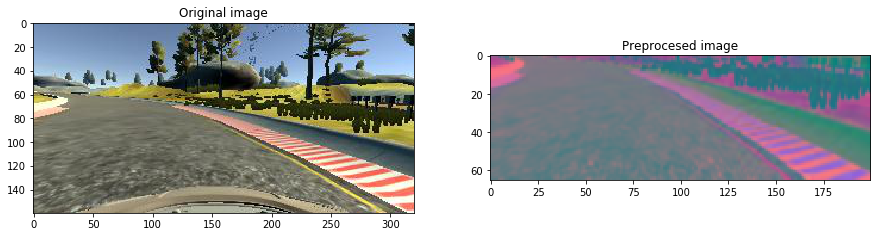

In [72]:
image=X_train[130]
original_image=mpimg.imread(image)
preprocessed_image=image_preprocess(image)
a=list(preprocessed_image)
fig, axs=plt.subplots(1,2 ,figsize=(15,10))
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocesed image')

In [0]:
# print(X_train[111].shape)
X_train=np.array(list(map(image_preprocess, X_train)))
X_valid=np.array(list(map(image_preprocess, X_valid)))


In [0]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
  model=Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dense(10, activation='elu'))
  model.add(Dense(1))
  optimizer=Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model  
  

In [0]:
model=nvidia_model()
print(model.summary())

In [0]:
history=model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epochs')


In [0]:
model.save('model.h5')

In [0]:
# from google.colab import files
# files.download('model.h5')